# Satellite Imagery Land Classification - Milestone 1


## Data Collection, Exploration, and Preprocessing

**Objectives:**
- Collect and preprocess satellite imagery data for land classification tasks
- Perform exploratory data analysis on multispectral satellite images  
- Apply feature engineering including vegetation indices (NDVI)

**Dataset:** EuroSAT Multispectral Dataset
**Source:** Zenodo (https://zenodo.org/records/7711810)

---

### INSTALL DEPENDENCIES AND MOUNT DRIVE

In [1]:
# Install required packages
!pip install rasterio albumentations

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Dependencies installed and Google Drive mounted!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.5 MB/s eta 0:00:00
Mounted at /content/drive
✅ Dependencies installed and Google Drive mounted!


### IMPORT LIBRARIES

In [2]:
# Standard library imports
import os
import zipfile
import pickle

In [3]:
# Data handling and numerical computing
import numpy as np
import pandas as pd

In [4]:
# Image processing and computer vision
import cv2
import rasterio
import albumentations as A

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Machine learning and data analysis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [8]:
# Web requests
import requests

In [9]:
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


### CONFIGURATION AND CONSTANTS

In [10]:
# Image processing parameters
IMAGE_SIZE = (64, 64)
BANDS = [1, 2, 3, 7]  # Selected spectral bands for processing
EXPECTED_BANDS = 13   # Expected number of bands for Sentinel-2 data

# Dataset configuration
DATASET_URL = "https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1"

In [11]:
# Land type categories
LAND_TYPES = [
    'Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake',
    'HerbaceousVegetation', 'Industrial', 'Residential',
    'PermanentCrop', 'Pasture'
]

In [12]:
# Sentinel-2 band information
BAND_LABELS = [
    "B01 - Aerosols",
    "B02 - Blue",
    "B03 - Green",
    "B04 - Red",
    "B05 - Red edge 1",
    "B06 - Red edge 2",
    "B07 - Red edge 3",
    "B08 - NIR",
    "B08A - Red edge 4",
    "B09 - Water vapor",
    "B10 - Cirrus",
    "B11 - SWIR 1",
    "B12 - SWIR 2"
]

In [13]:
# Color maps for band visualization
BAND_COLORS = [
    'gray',     # B01 - Aerosols
    'Blues',    # B02 - Blue
    'Greens',   # B03 - Green
    'Reds',     # B04 - Red
    'YlOrBr',   # B05 - Red edge 1
    'YlOrBr',   # B06 - Red edge 2
    'YlOrBr',   # B07 - Red edge 3
    'Oranges',  # B08 - NIR
    'Oranges',  # B08A - Red edge 4
    'Purples',  # B09 - Water vapor
    'Greys',    # B10 - Cirrus
    'PuRd',     # B11 - SWIR 1
    'PuBu',     # B12 - SWIR 2
]

In [14]:
# Data split configuration
TEST_SIZE = 0.2
VAL_SIZE = 0.25
RANDOM_STATE = 42

In [15]:
# Processing types
DATA_TYPES = ["RGB", "RGB_NIR", "NDVI"]

print("✅ Configuration variables set!")
print(f"📊 Land types to process: {len(LAND_TYPES)}")
print(f"🎨 Spectral bands available: {len(BAND_LABELS)}")

✅ Configuration variables set!
📊 Land types to process: 10
🎨 Spectral bands available: 13


### DIRECTORY SETUP

In [16]:
# Define base paths
BASE_PATH = "/content/drive/My Drive/DEPI/Data"
ORIGINAL_DATA_PATH = os.path.join(BASE_PATH, "Original_Data")
PROCESSED_DATA_PATH = os.path.join(BASE_PATH, "Processed_Data")

In [18]:
# Create main directories
os.makedirs(ORIGINAL_DATA_PATH, exist_ok=True)
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

In [19]:
# Create subdirectories for processed data types
for data_type in DATA_TYPES:
    type_path = os.path.join(PROCESSED_DATA_PATH, data_type)
    os.makedirs(type_path, exist_ok=True)
    print(f"✅ Created directory: {type_path}")

✅ Created directory: /content/drive/My Drive/DEPI/Data/Processed_Data/RGB
✅ Created directory: /content/drive/My Drive/DEPI/Data/Processed_Data/RGB_NIR
✅ Created directory: /content/drive/My Drive/DEPI/Data/Processed_Data/NDVI


In [20]:
# Define specific dataset path
EUROSAT_PATH = os.path.join(ORIGINAL_DATA_PATH, 'EuroSAT_MS')

print(f"\n📁 Directory structure created:")
print(f"   Original data: {ORIGINAL_DATA_PATH}")
print(f"   Processed data: {PROCESSED_DATA_PATH}")
print(f"   EuroSAT dataset: {EUROSAT_PATH}")


📁 Directory structure created:
   Original data: /content/drive/My Drive/DEPI/Data/Original_Data
   Processed data: /content/drive/My Drive/DEPI/Data/Processed_Data
   EuroSAT dataset: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS


### AUGMENTATION SETUP

In [21]:
# Configure image augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

print("✅ Augmentation pipeline configured:")
print("   - Horizontal flip (50% probability)")
print("   - Vertical flip (50% probability)")
print("   - Random brightness/contrast (20% probability)")

✅ Augmentation pipeline configured:
   - Horizontal flip (50% probability)
   - Vertical flip (50% probability)
   - Random brightness/contrast (20% probability)


### DATASET DOWNLOAD FUNCTION

In [22]:
def download_eurosat_dataset(destination=ORIGINAL_DATA_PATH):
    """
    Download and extract the EuroSAT dataset.

    Args:
        destination (str): Path where the dataset should be extracted
    """
    print("🌍 Starting EuroSAT dataset download...")

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)
    zip_path = os.path.join(destination, 'EuroSAT.zip')

    try:
        # Download dataset
        print("📥 Downloading EuroSAT Multispectral dataset...")
        with requests.get(DATASET_URL, stream=True) as response:
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))

            with open(zip_path, 'wb') as file:
                downloaded = 0
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        file.write(chunk)
                        downloaded += len(chunk)
                        if total_size > 0:
                            percent = (downloaded / total_size) * 100
                            print(f"\rProgress: {percent:.1f}%", end='', flush=True)

        print("\n📦 Extracting dataset...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destination)

        # Clean up zip file
        os.remove(zip_path)
        print(f"✅ Dataset successfully downloaded and extracted!")

    except Exception as e:
        print(f"❌ Error downloading dataset: {str(e)}")
        raise

print("✅ Download function defined!")

✅ Download function defined!


### DOWNLOAD AND VERIFY DATASET

In [23]:
# Check if dataset already exists, if not download it
if not os.path.exists(EUROSAT_PATH):
    print("📂 Dataset not found. Starting download...")
    download_eurosat_dataset()
else:
    print("✅ Dataset already exists!")

📂 Dataset not found. Starting download...
🌍 Starting EuroSAT dataset download...
📥 Downloading EuroSAT Multispectral dataset...
Progress: 100.0%
📦 Extracting dataset...
✅ Dataset successfully downloaded and extracted!


In [24]:
# Verify dataset structure
if os.path.exists(EUROSAT_PATH):
    print(f"\n📊 Dataset verification:")
    print(f"   Dataset path: {EUROSAT_PATH}")

    # List available categories
    categories = [d for d in os.listdir(EUROSAT_PATH) if os.path.isdir(os.path.join(EUROSAT_PATH, d))]
    print(f"   Categories found: {len(categories)}")

    for category in sorted(categories):
        category_path = os.path.join(EUROSAT_PATH, category)
        file_count = len([f for f in os.listdir(category_path) if f.endswith('.tif')])
        print(f"      - {category}: {file_count} images")
else:
    print("❌ Dataset verification failed!")


📊 Dataset verification:
   Dataset path: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS
   Categories found: 10
      - AnnualCrop: 3000 images
      - Forest: 3000 images
      - HerbaceousVegetation: 3000 images
      - Highway: 2500 images
      - Industrial: 2500 images
      - Pasture: 2000 images
      - PermanentCrop: 2500 images
      - Residential: 3000 images
      - River: 2500 images
      - SeaLake: 3000 images


### UTILITY FUNCTIONS FOR DATA EXPLORATION

In [25]:
def count_images_in_folders(root_path, file_extension='.tif'):
    """
    Count images in folder structure and display statistics.

    Args:
        root_path (str): Root directory path
        file_extension (str): File extension to count
    """
    for main_dir in os.listdir(root_path):
        main_dir_path = os.path.join(root_path, main_dir)
        if not os.path.isdir(main_dir_path):
            continue

        print(f"\n📁 {main_dir} Folder:")
        total_images = 0

        for category in os.listdir(main_dir_path):
            category_path = os.path.join(main_dir_path, category)
            if not os.path.isdir(category_path):
                continue

            image_count = len([
                file for file in os.listdir(category_path)
                if file.lower().endswith(file_extension)
            ])

            total_images += image_count
            print(f"  📂 {category}: {image_count} images")

        print(f"🔢 Total in {main_dir}: {total_images} images")

In [26]:
def display_setup_summary():
    """Display a summary of the current setup configuration."""
    print("🎯 SETUP SUMMARY")
    print("=" * 50)
    print(f"📁 Original data path: {ORIGINAL_DATA_PATH}")
    print(f"📁 Processed data path: {PROCESSED_DATA_PATH}")
    print(f"📁 EuroSAT dataset path: {EUROSAT_PATH}")
    print(f"🖼️  Image size: {IMAGE_SIZE}")
    print(f"📊 Selected bands: {BANDS}")
    print(f"🏷️  Land types: {len(LAND_TYPES)}")
    print(f"🎨 Data types to generate: {DATA_TYPES}")
    print(f"🔄 Augmentation: Enabled")
    print("=" * 50)
    print("✅ Setup completed successfully!")

print("✅ Utility functions defined!")

✅ Utility functions defined!


### FINAL SETUP VERIFICATION

In [27]:
# Display setup summary
display_setup_summary()

🎯 SETUP SUMMARY
📁 Original data path: /content/drive/My Drive/DEPI/Data/Original_Data
📁 Processed data path: /content/drive/My Drive/DEPI/Data/Processed_Data
📁 EuroSAT dataset path: /content/drive/My Drive/DEPI/Data/Original_Data/EuroSAT_MS
🖼️  Image size: (64, 64)
📊 Selected bands: [1, 2, 3, 7]
🏷️  Land types: 10
🎨 Data types to generate: ['RGB', 'RGB_NIR', 'NDVI']
🔄 Augmentation: Enabled
✅ Setup completed successfully!


In [28]:
# Count original dataset images
print("\n📊 Original dataset statistics:")
count_images_in_folders(ORIGINAL_DATA_PATH)


📊 Original dataset statistics:

📁 EuroSAT_MS Folder:
  📂 Forest: 3000 images
  📂 River: 2500 images
  📂 Highway: 2500 images
  📂 AnnualCrop: 3000 images
  📂 SeaLake: 3000 images
  📂 HerbaceousVegetation: 3000 images
  📂 Industrial: 2500 images
  📂 Residential: 3000 images
  📂 PermanentCrop: 2500 images
  📂 Pasture: 2000 images
🔢 Total in EuroSAT_MS: 27000 images


In [29]:
# Verify sample image properties
sample_image_path = None
for root, dirs, files in os.walk(EUROSAT_PATH):
    for file in files:
        if file.endswith(".tif"):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

In [30]:
if sample_image_path:
    with rasterio.open(sample_image_path) as src:
        num_bands = src.count
        width, height = src.width, src.height
        print(f"\n🖼️  Sample image analysis:")
        print(f"   File: {os.path.basename(sample_image_path)}")
        print(f"   Dimensions: {width} x {height}")
        print(f"   Spectral bands: {num_bands}")
        print(f"   Data type: {src.dtypes[0]}")
else:
    print("❌ No sample image found!")


🖼️  Sample image analysis:
   File: Forest_2230.tif
   Dimensions: 64 x 64
   Spectral bands: 13
   Data type: uint16


---

In [31]:
print("\n🚀 Ready to proceed with data exploration and preprocessing!")


🚀 Ready to proceed with data exploration and preprocessing!


---

## IMAGE PROCESSING

This section builds on the setup configuration already defined above


## IMPORTING

In [32]:
import logging
from typing import Tuple, Optional, List, Union, Dict
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings

In [33]:
# Configure logging for processing feedback
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [34]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### IMAGE PROCESSOR

In [35]:
class SatelliteImageProcessor:
    """
    Optimized processor for satellite imagery with error handling and efficiency optimizations.
    Uses the configuration variables already defined in the setup section.
    """

    def __init__(self):
        """Initialize using the global configuration variables."""
        self.image_size = IMAGE_SIZE
        self.expected_bands = EXPECTED_BANDS
        self.augmentation = augmentation  # Use the already defined augmentation pipeline
        self._metadata_cache = {}

        logger.info(f"Initialized SatelliteImageProcessor with size {self.image_size}")

    def validate_image_file(self, image_path: str) -> Dict[str, Union[bool, str, int]]:
        """
        Validate a single image file for integrity and expected properties.

        Args:
            image_path: Path to the image file

        Returns:
            Dictionary containing validation results
        """
        result = {
            'valid': False,
            'error': None,
            'bands': 0,
            'width': 0,
            'height': 0,
            'dtype': None
        }

        try:
            if not os.path.exists(image_path):
                result['error'] = 'File does not exist'
                return result

            with rasterio.open(image_path) as src:
                result['bands'] = src.count
                result['width'] = src.width
                result['height'] = src.height
                result['dtype'] = str(src.dtypes[0])

                # Check for correct number of bands
                if src.count != self.expected_bands:
                    result['error'] = f'Unexpected band count: {src.count}/{self.expected_bands}'
                    return result

                # Quick data quality check on first band
                sample_data = src.read(1, window=rasterio.windows.Window(0, 0, 100, 100))

                if np.isnan(sample_data).any() or np.isinf(sample_data).any():
                    result['error'] = 'Contains NaN or Inf values'
                    return result

                if np.std(sample_data) < 1e-6:
                    result['error'] = 'Constant values detected'
                    return result

                result['valid'] = True

        except Exception as e:
            result['error'] = f'Error: {str(e)}'

        return result

    def load_tiff_image(self, image_path: str, bands: Optional[List[int]] = None) -> Optional[np.ndarray]:
        """
        Load and normalize a TIFF image with specified bands.

        Args:
            image_path: Path to the TIFF file
            bands: List of band indices to load (1-based). If None, loads all bands

        Returns:
            Normalized image array (H, W, C) or None if loading failed
        """
        try:
            with rasterio.open(image_path) as src:
                if bands is None:
                    bands = list(range(1, src.count + 1))

                # Read selected bands
                img = src.read(bands).astype(np.float32)

                # Transpose to (H, W, C) format
                img = np.transpose(img, (1, 2, 0))

                # Resize if needed
                if img.shape[:2] != self.image_size:
                    img = cv2.resize(img, self.image_size, interpolation=cv2.INTER_LINEAR)

                # Normalize to [0, 1] range with numerical stability
                img_min, img_max = img.min(), img.max()
                if img_max - img_min > 1e-8:
                    img = (img - img_min) / (img_max - img_min)
                else:
                    img = np.zeros_like(img)

                return img

        except Exception as e:
            logger.error(f"Error loading {image_path}: {str(e)}")
            return None

    def load_rgb_image(self, image_path: str, bands: List[int] = [4, 3, 2]) -> Optional[np.ndarray]:
        """Load RGB image using specified bands (Red, Green, Blue for Sentinel-2)."""
        return self.load_tiff_image(image_path, bands)

    def load_rgb_nir_image(self, image_path: str, bands: List[int] = [4, 3, 2, 8]) -> Optional[np.ndarray]:
        """Load RGB + NIR image using specified bands."""
        return self.load_tiff_image(image_path, bands)

    def compute_ndvi(self, image: np.ndarray, nir_band: int = 3, red_band: int = 0) -> np.ndarray:
        """
        Compute Normalized Difference Vegetation Index (NDVI).

        Args:
            image: Image array with NIR and Red bands
            nir_band: Index of Near-Infrared band in the image array
            red_band: Index of Red band in the image array

        Returns:
            NDVI array (H, W)
        """
        try:
            nir = image[:, :, nir_band].astype(np.float32)
            red = image[:, :, red_band].astype(np.float32)

            # Calculate NDVI with numerical stability
            denominator = nir + red + 1e-8
            ndvi = (nir - red) / denominator

            # Clip to valid NDVI range [-1, 1]
            ndvi = np.clip(ndvi, -1, 1)

            return ndvi

        except IndexError as e:
            logger.error(f"Band index error in NDVI computation: {str(e)}")
            return np.zeros((self.image_size[1], self.image_size[0]), dtype=np.float32)
        except Exception as e:
            logger.error(f"Error computing NDVI: {str(e)}")
            return np.zeros((self.image_size[1], self.image_size[0]), dtype=np.float32)

    def apply_augmentation(self, image: np.ndarray) -> np.ndarray:
        """
        Apply augmentation to an image using the pre-defined augmentation pipeline.

        Args:
            image: Input image array

        Returns:
            Augmented image array
        """
        try:
            # Convert to uint8 for albumentations
            if image.max() <= 1.0:
                image_uint8 = (image * 255).astype(np.uint8)
            else:
                image_uint8 = image.astype(np.uint8)

            # Apply augmentation
            augmented = self.augmentation(image=image_uint8)['image']

            # Convert back to float32
            return augmented.astype(np.float32) / 255.0

        except Exception as e:
            logger.error(f"Error applying augmentation: {str(e)}")
            return image

    def process_single_image(self, image_path: str, category: str) -> Dict[str, bool]:
        """
        Process a single image and save all variants (RGB, RGB+NIR, NDVI).
        Uses the global PROCESSED_DATA_PATH for output.

        Args:
            image_path: Path to input image
            category: Category/class name

        Returns:
            Dictionary indicating success/failure for each processing type
        """
        results = {'rgb': False, 'rgb_nir': False, 'ndvi': False, 'augmented': False}

        try:
            base_name = os.path.splitext(os.path.basename(image_path))[0]

            # Load different image variants
            rgb_img = self.load_rgb_image(image_path)
            rgb_nir_img = self.load_rgb_nir_image(image_path)

            if rgb_img is None or rgb_nir_img is None:
                logger.warning(f"Failed to load image: {image_path}")
                return results

            # Compute NDVI
            ndvi_img = self.compute_ndvi(rgb_nir_img)

            # Create category directories using global paths
            for data_type in DATA_TYPES:
                cat_dir = os.path.join(PROCESSED_DATA_PATH, data_type, category)
                os.makedirs(cat_dir, exist_ok=True)

            # Save original versions
            try:
                np.save(os.path.join(PROCESSED_DATA_PATH, 'RGB', category, f'{base_name}.npy'), rgb_img)
                results['rgb'] = True
            except Exception as e:
                logger.error(f"Error saving RGB image {base_name}: {str(e)}")

            try:
                np.save(os.path.join(PROCESSED_DATA_PATH, 'RGB_NIR', category, f'{base_name}.npy'), rgb_nir_img)
                results['rgb_nir'] = True
            except Exception as e:
                logger.error(f"Error saving RGB_NIR image {base_name}: {str(e)}")

            try:
                np.save(os.path.join(PROCESSED_DATA_PATH, 'NDVI', category, f'{base_name}.npy'), ndvi_img)
                results['ndvi'] = True
            except Exception as e:
                logger.error(f"Error saving NDVI image {base_name}: {str(e)}")

            # Save augmented RGB version
            try:
                rgb_aug = self.apply_augmentation(rgb_img)
                np.save(os.path.join(PROCESSED_DATA_PATH, 'RGB', category, f'{base_name}_aug.npy'), rgb_aug)
                results['augmented'] = True
            except Exception as e:
                logger.error(f"Error saving augmented image {base_name}: {str(e)}")

        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")

        return results

In [37]:
# Initialize the processor
processor = SatelliteImageProcessor()
print("✅ SatelliteImageProcessor initialized and ready!")

✅ SatelliteImageProcessor initialized and ready!


### DATASET VALIDATION AND PROCESSING FUNCTIONS

In [38]:
def validate_dataset(max_workers: int = 4) -> Dict[str, any]:
    """
    Validate the EuroSAT dataset using parallel processing.

    Args:
        max_workers: Number of parallel workers

    Returns:
        Dictionary containing validation statistics
    """
    logger.info("Starting dataset validation...")

    stats = {
        'total_files': 0,
        'valid_files': 0,
        'corrupted_files': 0,
        'categories': {},
        'errors': []
    }

    # Collect all image files
    image_files = []
    for category in LAND_TYPES:
        category_path = os.path.join(EUROSAT_PATH, category)
        if not os.path.exists(category_path):
            logger.warning(f"Category directory not found: {category}")
            continue

        stats['categories'][category] = {'total': 0, 'valid': 0, 'errors': []}

        for filename in os.listdir(category_path):
            if filename.lower().endswith('.tif'):
                image_files.append((os.path.join(category_path, filename), category))
                stats['categories'][category]['total'] += 1
                stats['total_files'] += 1

    print(f"🔍 Validating {stats['total_files']} images across {len(stats['categories'])} categories...")

    # Parallel validation
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_file = {
            executor.submit(processor.validate_image_file, file_path): (file_path, category)
            for file_path, category in image_files
        }

        completed = 0
        for future in as_completed(future_to_file):
            file_path, category = future_to_file[future]
            completed += 1

            if completed % 500 == 0:
                print(f"   Progress: {completed}/{len(image_files)} files validated...")

            try:
                result = future.result()
                if result['valid']:
                    stats['valid_files'] += 1
                    stats['categories'][category]['valid'] += 1
                else:
                    stats['corrupted_files'] += 1
                    error_info = f"{os.path.basename(file_path)}: {result['error']}"
                    stats['categories'][category]['errors'].append(error_info)
                    if len(stats['errors']) < 20:  # Limit stored errors
                        stats['errors'].append(error_info)

            except Exception as e:
                stats['corrupted_files'] += 1
                error_info = f"{os.path.basename(file_path)}: {str(e)}"
                stats['categories'][category]['errors'].append(error_info)
                if len(stats['errors']) < 20:
                    stats['errors'].append(error_info)

    logger.info(f"Validation complete: {stats['valid_files']}/{stats['total_files']} files valid")
    return stats

In [42]:
def process_dataset(max_workers: int = 4, sample_size: Optional[int] = None) -> Dict[str, int]:
    """
    Process the EuroSAT dataset using parallel processing.

    Args:
        max_workers: Number of parallel workers
        sample_size: If specified, process only this many images per category (for testing)

    Returns:
        Dictionary containing processing statistics
    """
    logger.info("Starting batch dataset processing...")

    stats = {
        'total_processed': 0,
        'successful': 0,
        'failed': 0,
        'categories': {}
    }

    # Collect all processing tasks
    tasks = []
    for category in LAND_TYPES:
        category_path = os.path.join(EUROSAT_PATH, category)
        if not os.path.exists(category_path):
            logger.warning(f"Category directory not found: {category}")
            continue

        stats['categories'][category] = {'processed': 0, 'failed': 0}

        files = [f for f in os.listdir(category_path) if f.lower().endswith('.tif')]

        # Apply sample size limit if specified
        if sample_size:
            files = files[:sample_size]

        for filename in files:
            image_path = os.path.join(category_path, filename)
            tasks.append((image_path, category))

    stats['total_processed'] = len(tasks)
    print(f"🔄 Processing {len(tasks)} images...")

    # Process in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_task = {
            executor.submit(processor.process_single_image, image_path, category):
            (image_path, category)
            for image_path, category in tasks
        }

        completed = 0
        for future in as_completed(future_to_task):
            image_path, category = future_to_task[future]
            completed += 1

            if completed % 100 == 0:
                print(f"   Progress: {completed}/{len(tasks)} images processed...")

            try:
                results = future.result()
                if any(results.values()):
                    stats['successful'] += 1
                    stats['categories'][category]['processed'] += 1
                else:
                    stats['failed'] += 1
                    stats['categories'][category]['failed'] += 1

            except Exception as e:
                stats['failed'] += 1
                stats['categories'][category]['failed'] += 1
                logger.error(f"Failed to process {image_path}: {str(e)}")

    logger.info(f"Processing complete: {stats['successful']}/{stats['total_processed']} successful")
    return stats

def display_processing_summary(stats: Dict[str, any], title: str = "PROCESSING SUMMARY") -> None:
    """
    Display a formatted summary of processing statistics.

    Args:
        stats: Statistics dictionary from processing operations
        title: Title for the summary display
    """
    print("\n" + "="*60)
    print(f"📊 {title}")
    print("="*60)

    if 'total_processed' in stats:
        print(f"🎯 Total images processed: {stats['total_processed']}")
        print(f"✅ Successful: {stats['successful']}")
        print(f"❌ Failed: {stats['failed']}")
        if stats['total_processed'] > 0:
            success_rate = (stats['successful'] / stats['total_processed']) * 100
            print(f"📈 Success rate: {success_rate:.1f}%")

        print(f"\n📋 Category breakdown:")
        for category, cat_stats in stats['categories'].items():
            total = cat_stats['processed'] + cat_stats['failed']
            print(f"   {category}: {cat_stats['processed']}/{total} successful")

    elif 'total_files' in stats:
        print(f"🎯 Total files validated: {stats['total_files']}")
        print(f"✅ Valid files: {stats['valid_files']}")
        print(f"❌ Corrupted files: {stats['corrupted_files']}")
        if stats['total_files'] > 0:
            validity_rate = (stats['valid_files'] / stats['total_files']) * 100
            print(f"📈 Validity rate: {validity_rate:.1f}%")

        print(f"\n📋 Category breakdown:")
        for category, cat_stats in stats['categories'].items():
            if cat_stats['total'] > 0:
                valid_rate = (cat_stats['valid'] / cat_stats['total']) * 100
                print(f"   {category}: {cat_stats['valid']}/{cat_stats['total']} valid ({valid_rate:.1f}%)")

        if stats['errors']:
            print(f"\n⚠️  Sample errors (showing first 5):")
            for error in stats['errors'][:5]:
                print(f"   {error}")

    print("="*60)

In [43]:
print("✅ Processing functions defined and ready to use!")

✅ Processing functions defined and ready to use!


### EXECUTING

In [44]:
print("🔍 Starting dataset validation...")
validation_stats = validate_dataset(max_workers=4)
display_processing_summary(validation_stats, "DATASET VALIDATION")

🔍 Starting dataset validation...
🔍 Validating 27000 images across 10 categories...
   Progress: 500/27000 files validated...
   Progress: 1000/27000 files validated...
   Progress: 1500/27000 files validated...
   Progress: 2000/27000 files validated...
   Progress: 2500/27000 files validated...
   Progress: 3000/27000 files validated...
   Progress: 3500/27000 files validated...
   Progress: 4000/27000 files validated...
   Progress: 4500/27000 files validated...
   Progress: 5000/27000 files validated...
   Progress: 5500/27000 files validated...
   Progress: 6000/27000 files validated...
   Progress: 6500/27000 files validated...
   Progress: 7000/27000 files validated...
   Progress: 7500/27000 files validated...
   Progress: 8000/27000 files validated...
   Progress: 8500/27000 files validated...
   Progress: 9000/27000 files validated...
   Progress: 9500/27000 files validated...
   Progress: 10000/27000 files validated...
   Progress: 10500/27000 files validated...
   Progress: 

In [45]:
print("🧪 Starting sample processing (10 images per category)...")
sample_stats = process_dataset(max_workers=2, sample_size=10)
display_processing_summary(sample_stats, "SAMPLE PROCESSING")

🧪 Starting sample processing (10 images per category)...
🔄 Processing 100 images...
   Progress: 100/100 images processed...

📊 SAMPLE PROCESSING
🎯 Total images processed: 100
✅ Successful: 100
❌ Failed: 0
📈 Success rate: 100.0%

📋 Category breakdown:
   Forest: 10/10 successful
   River: 10/10 successful
   Highway: 10/10 successful
   AnnualCrop: 10/10 successful
   SeaLake: 10/10 successful
   HerbaceousVegetation: 10/10 successful
   Industrial: 10/10 successful
   Residential: 10/10 successful
   PermanentCrop: 10/10 successful
   Pasture: 10/10 successful


In [46]:
print("\n📁 Checking processed data structure:")
count_images_in_folders(PROCESSED_DATA_PATH, '.npy')


📁 Checking processed data structure:

📁 RGB Folder:
  📂 Forest: 20 images
  📂 River: 20 images
  📂 Highway: 20 images
  📂 AnnualCrop: 20 images
  📂 SeaLake: 20 images
  📂 HerbaceousVegetation: 20 images
  📂 Industrial: 20 images
  📂 Residential: 20 images
  📂 PermanentCrop: 20 images
  📂 Pasture: 20 images
🔢 Total in RGB: 200 images

📁 RGB_NIR Folder:
  📂 Forest: 10 images
  📂 River: 10 images
  📂 Highway: 10 images
  📂 AnnualCrop: 10 images
  📂 SeaLake: 10 images
  📂 HerbaceousVegetation: 10 images
  📂 Industrial: 10 images
  📂 Residential: 10 images
  📂 PermanentCrop: 10 images
  📂 Pasture: 10 images
🔢 Total in RGB_NIR: 100 images

📁 NDVI Folder:
  📂 Forest: 10 images
  📂 River: 10 images
  📂 Highway: 10 images
  📂 AnnualCrop: 10 images
  📂 SeaLake: 10 images
  📂 HerbaceousVegetation: 10 images
  📂 Industrial: 10 images
  📂 Residential: 10 images
  📂 PermanentCrop: 10 images
  📂 Pasture: 10 images
🔢 Total in NDVI: 100 images


In [47]:
print("🔄 Starting full dataset processing...")
processing_stats = process_dataset(max_workers=4)
display_processing_summary(processing_stats, "FULL DATASET PROCESSING")

🔄 Starting full dataset processing...
🔄 Processing 27000 images...
   Progress: 100/27000 images processed...
   Progress: 200/27000 images processed...
   Progress: 300/27000 images processed...
   Progress: 400/27000 images processed...
   Progress: 500/27000 images processed...
   Progress: 600/27000 images processed...
   Progress: 700/27000 images processed...
   Progress: 800/27000 images processed...
   Progress: 900/27000 images processed...
   Progress: 1000/27000 images processed...
   Progress: 1100/27000 images processed...
   Progress: 1200/27000 images processed...
   Progress: 1300/27000 images processed...
   Progress: 1400/27000 images processed...
   Progress: 1500/27000 images processed...
   Progress: 1600/27000 images processed...
   Progress: 1700/27000 images processed...
   Progress: 1800/27000 images processed...
   Progress: 1900/27000 images processed...
   Progress: 2000/27000 images processed...
   Progress: 2100/27000 images processed...
   Progress: 2200/

In [48]:
print("\n📁 Final processed data structure:")
count_images_in_folders(PROCESSED_DATA_PATH, '.npy')


📁 Final processed data structure:

📁 RGB Folder:
  📂 Forest: 6000 images
  📂 River: 5000 images
  📂 Highway: 5000 images
  📂 AnnualCrop: 6000 images
  📂 SeaLake: 6000 images
  📂 HerbaceousVegetation: 6000 images
  📂 Industrial: 5000 images
  📂 Residential: 6000 images
  📂 PermanentCrop: 5000 images
  📂 Pasture: 4000 images
🔢 Total in RGB: 54000 images

📁 RGB_NIR Folder:
  📂 Forest: 3000 images
  📂 River: 2500 images
  📂 Highway: 2500 images
  📂 AnnualCrop: 3000 images
  📂 SeaLake: 3000 images
  📂 HerbaceousVegetation: 3000 images
  📂 Industrial: 2500 images
  📂 Residential: 3000 images
  📂 PermanentCrop: 2500 images
  📂 Pasture: 2000 images
🔢 Total in RGB_NIR: 27000 images

📁 NDVI Folder:
  📂 Forest: 3000 images
  📂 River: 2500 images
  📂 Highway: 2500 images
  📂 AnnualCrop: 3000 images
  📂 SeaLake: 3000 images
  📂 HerbaceousVegetation: 3000 images
  📂 Industrial: 2500 images
  📂 Residential: 3000 images
  📂 PermanentCrop: 2500 images
  📂 Pasture: 2000 images
🔢 Total in NDVI: 27000 im

In [49]:
def visualize_processed_samples(category='Forest', num_samples=3):
    """Visualize processed samples from a category"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    category_path_rgb = os.path.join(PROCESSED_DATA_PATH, 'RGB', category)
    category_path_ndvi = os.path.join(PROCESSED_DATA_PATH, 'NDVI', category)

    if os.path.exists(category_path_rgb):
        files = [f for f in os.listdir(category_path_rgb) if f.endswith('.npy') and not f.endswith('_aug.npy')]

        for i in range(min(num_samples, len(files))):
            # Load RGB
            rgb_file = files[i]
            rgb_img = np.load(os.path.join(category_path_rgb, rgb_file))

            # Load RGB+NIR
            rgb_nir_file = rgb_file
            rgb_nir_path = os.path.join(PROCESSED_DATA_PATH, 'RGB_NIR', category, rgb_nir_file)
            if os.path.exists(rgb_nir_path):
                rgb_nir_img = np.load(rgb_nir_path)
            else:
                rgb_nir_img = np.zeros_like(rgb_img)

            # Load NDVI
            ndvi_file = rgb_file
            ndvi_path = os.path.join(category_path_ndvi, ndvi_file)
            if os.path.exists(ndvi_path):
                ndvi_img = np.load(ndvi_path)
            else:
                ndvi_img = np.zeros((rgb_img.shape[0], rgb_img.shape[1]))

            # Plot RGB
            axes[i, 0].imshow(rgb_img)
            axes[i, 0].set_title(f'RGB - {category} {i+1}')
            axes[i, 0].axis('off')

            # Plot NIR (if available)
            if rgb_nir_img.shape[2] > 3:
                axes[i, 1].imshow(rgb_nir_img[:,:,3], cmap='RdYlGn')
                axes[i, 1].set_title(f'NIR Band - {category} {i+1}')
            else:
                axes[i, 1].text(0.5, 0.5, 'NIR not available', ha='center', va='center')
                axes[i, 1].set_title(f'NIR Band - {category} {i+1}')
            axes[i, 1].axis('off')

            # Plot NDVI
            im = axes[i, 2].imshow(ndvi_img, cmap='RdYlGn', vmin=-1, vmax=1)
            axes[i, 2].set_title(f'NDVI - {category} {i+1}')
            axes[i, 2].axis('off')

            # Add colorbar for NDVI
            plt.colorbar(im, ax=axes[i, 2], fraction=0.046)

    plt.tight_layout()
    plt.show()

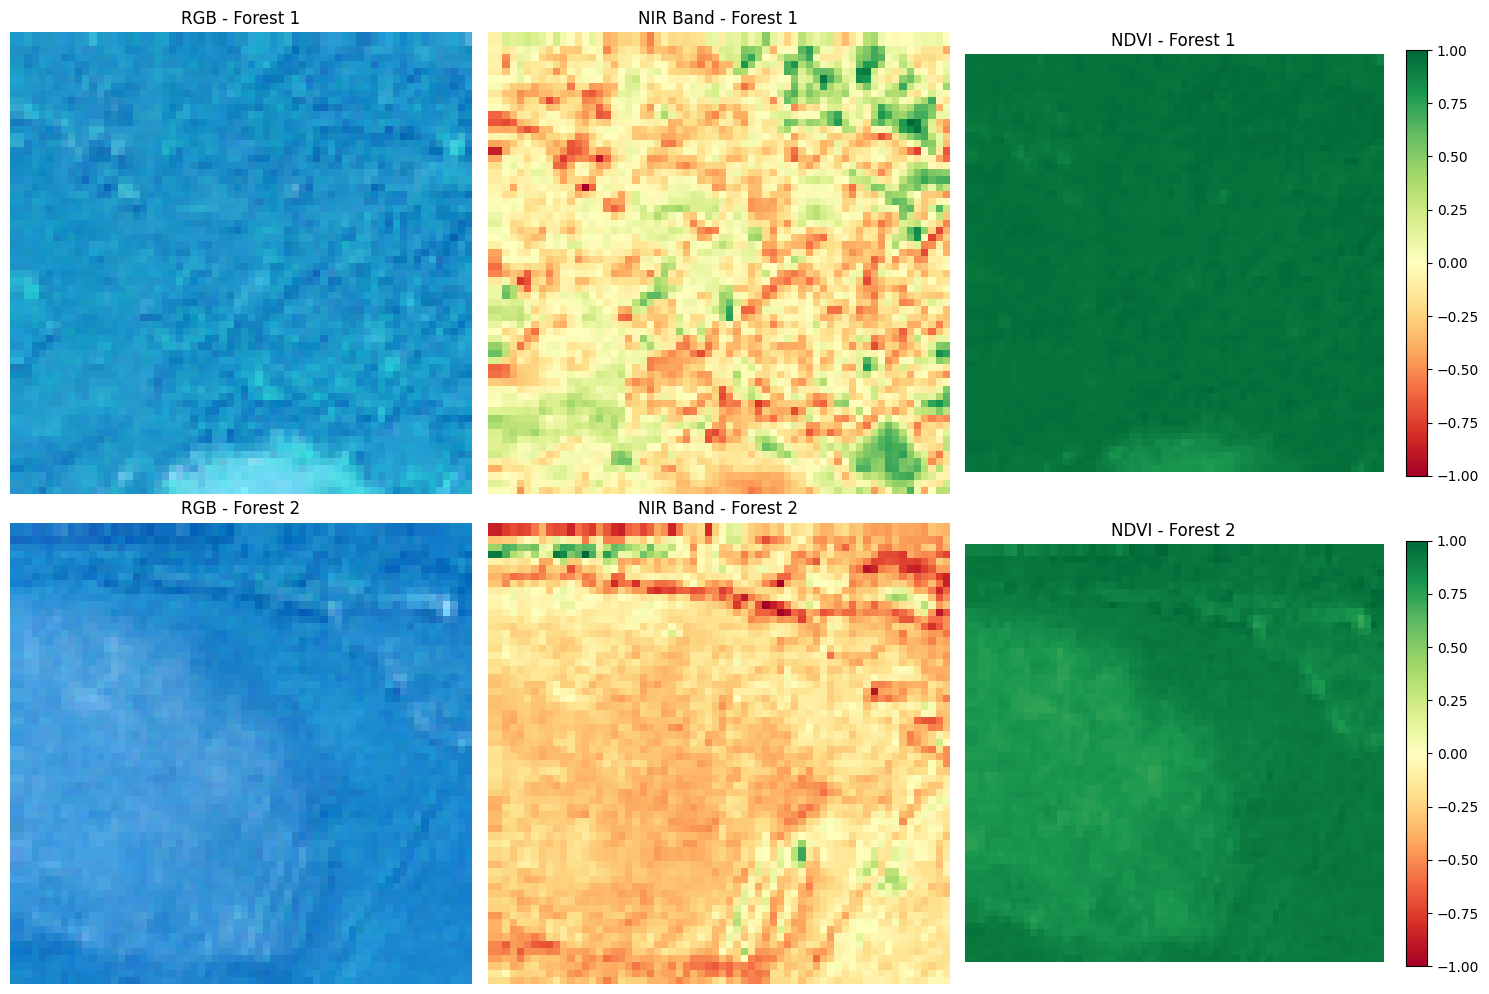

In [50]:
# Visualize samples
visualize_processed_samples('Forest', 2)

### MORE INSIGHTS

In [51]:
def create_comprehensive_eda_visualizations():
    """Create comprehensive visualizations for EDA report"""

    # 1. Dataset Distribution Visualization
    def plot_dataset_distribution():
        """Plot class distribution across the dataset"""
        categories = []
        counts = []

        for category in LAND_TYPES:
            category_path = os.path.join(EUROSAT_PATH, category)
            if os.path.exists(category_path):
                count = len([f for f in os.listdir(category_path) if f.endswith('.tif')])
                categories.append(category)
                counts.append(count)

        plt.figure(figsize=(12, 6))
        bars = plt.bar(categories, counts, color=plt.cm.tab10(np.linspace(0, 1, len(categories))))
        plt.title('EuroSAT Dataset - Class Distribution', fontsize=16, fontweight='bold')
        plt.xlabel('Land Type Categories', fontsize=12)
        plt.ylabel('Number of Images', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                    str(count), ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"📊 Dataset Statistics:")
        print(f"   Total Categories: {len(categories)}")
        print(f"   Total Images: {sum(counts)}")
        print(f"   Average per Category: {np.mean(counts):.0f}")
        print(f"   Min: {min(counts)}, Max: {max(counts)}")

    # 2. Spectral Band Analysis
    def plot_spectral_signatures():
        """Plot average spectral signatures for each land type"""
        spectral_data = {}

        # Sample a few images from each category
        for category in LAND_TYPES[:5]:  # Limit to 5 categories for clarity
            category_path = os.path.join(EUROSAT_PATH, category)
            if os.path.exists(category_path):
                files = [f for f in os.listdir(category_path) if f.endswith('.tif')]

                if files:
                    # Load first image as sample
                    sample_path = os.path.join(category_path, files[0])
                    try:
                        with rasterio.open(sample_path) as src:
                            # Read all bands and calculate mean
                            spectral_mean = []
                            for band in range(1, min(14, src.count + 1)):
                                band_data = src.read(band)
                                spectral_mean.append(np.mean(band_data))
                            spectral_data[category] = spectral_mean
                    except Exception as e:
                        print(f"Error loading {category}: {e}")

        # Plot spectral signatures
        plt.figure(figsize=(14, 8))
        colors = plt.cm.tab10(np.linspace(0, 1, len(spectral_data)))

        for i, (category, signature) in enumerate(spectral_data.items()):
            bands = range(1, len(signature) + 1)
            plt.plot(bands, signature, 'o-', color=colors[i],
                    label=category, linewidth=2, markersize=6)

        plt.title('Average Spectral Signatures by Land Type', fontsize=16, fontweight='bold')
        plt.xlabel('Spectral Band', fontsize=12)
        plt.ylabel('Average Reflectance', fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

        # Add band labels
        band_names = [f"B{i:02d}" for i in range(1, 14)]
        plt.xticks(range(1, 14), band_names, rotation=45)

        plt.tight_layout()
        plt.show()

    # 3. NDVI Distribution Analysis
    def plot_ndvi_distributions():
        """Plot NDVI value distributions for different land types"""
        ndvi_data = {}

        for category in LAND_TYPES:
            ndvi_path = os.path.join(PROCESSED_DATA_PATH, 'NDVI', category)
            if os.path.exists(ndvi_path):
                files = [f for f in os.listdir(ndvi_path) if f.endswith('.npy')]

                ndvi_values = []
                for file in files[:10]:  # Sample 10 files per category
                    try:
                        ndvi_img = np.load(os.path.join(ndvi_path, file))
                        ndvi_values.extend(ndvi_img.flatten())
                    except Exception as e:
                        continue

                if ndvi_values:
                    ndvi_data[category] = ndvi_values

        # Create subplot for histograms
        fig, axes = plt.subplots(2, 5, figsize=(20, 10))
        axes = axes.flatten()

        for i, (category, values) in enumerate(ndvi_data.items()):
            if i < len(axes):
                axes[i].hist(values, bins=50, alpha=0.7, density=True)
                axes[i].set_title(f'{category}\nMean NDVI: {np.mean(values):.3f}', fontweight='bold')
                axes[i].set_xlabel('NDVI Value')
                axes[i].set_ylabel('Density')
                axes[i].grid(True, alpha=0.3)
                axes[i].axvline(np.mean(values), color='red', linestyle='--', linewidth=2)

        # Hide unused subplots
        for j in range(len(ndvi_data), len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('NDVI Value Distributions by Land Type', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print NDVI statistics
        print("\n📊 NDVI Statistics by Land Type:")
        for category, values in ndvi_data.items():
            print(f"   {category:20}: Mean={np.mean(values):.3f}, Std={np.std(values):.3f}")

    # 4. Sample Images Grid
    def plot_sample_images_grid():
        """Create a comprehensive grid of sample images"""
        categories = LAND_TYPES[:6]  # Show 6 categories

        fig, axes = plt.subplots(6, 4, figsize=(16, 24))

        for i, category in enumerate(categories):
            # RGB
            rgb_path = os.path.join(PROCESSED_DATA_PATH, 'RGB', category)
            if os.path.exists(rgb_path):
                files = [f for f in os.listdir(rgb_path) if f.endswith('.npy') and not f.endswith('_aug.npy')]
                if files:
                    rgb_img = np.load(os.path.join(rgb_path, files[0]))
                    axes[i, 0].imshow(rgb_img)
                    axes[i, 0].set_title(f'{category} - RGB')
                    axes[i, 0].axis('off')

            # RGB+NIR (show NIR band)
            rgb_nir_path = os.path.join(PROCESSED_DATA_PATH, 'RGB_NIR', category)
            if os.path.exists(rgb_nir_path):
                files = [f for f in os.listdir(rgb_nir_path) if f.endswith('.npy')]
                if files:
                    rgb_nir_img = np.load(os.path.join(rgb_nir_path, files[0]))
                    if rgb_nir_img.shape[2] > 3:
                        axes[i, 1].imshow(rgb_nir_img[:,:,3], cmap='RdYlGn')
                        axes[i, 1].set_title(f'{category} - NIR Band')
                    axes[i, 1].axis('off')

            # NDVI
            ndvi_path = os.path.join(PROCESSED_DATA_PATH, 'NDVI', category)
            if os.path.exists(ndvi_path):
                files = [f for f in os.listdir(ndvi_path) if f.endswith('.npy')]
                if files:
                    ndvi_img = np.load(os.path.join(ndvi_path, files[0]))
                    im = axes[i, 2].imshow(ndvi_img, cmap='RdYlGn', vmin=-1, vmax=1)
                    axes[i, 2].set_title(f'{category} - NDVI')
                    axes[i, 2].axis('off')

            # Augmented RGB
            if os.path.exists(rgb_path):
                aug_files = [f for f in os.listdir(rgb_path) if f.endswith('_aug.npy')]
                if aug_files:
                    aug_img = np.load(os.path.join(rgb_path, aug_files[0]))
                    axes[i, 3].imshow(aug_img)
                    axes[i, 3].set_title(f'{category} - Augmented')
                    axes[i, 3].axis('off')

        plt.suptitle('Sample Images Across Processing Types', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Execute all visualizations
    print("🎨 Creating comprehensive EDA visualizations...")
    plot_dataset_distribution()
    plot_spectral_signatures()
    plot_ndvi_distributions()
    plot_sample_images_grid()
    print("✅ All visualizations created!")

In [ ]:
def create_data_splits():
    """Create train/validation/test splits and organize data accordingly"""

    # Create split directories
    split_base_path = os.path.join(PROCESSED_DATA_PATH, "splits")
    os.makedirs(split_base_path, exist_ok=True)

    for split in ['train', 'validation', 'test']:
        for data_type in DATA_TYPES:
            split_path = os.path.join(split_base_path, split, data_type)
            os.makedirs(split_path, exist_ok=True)

            for category in LAND_TYPES:
                category_path = os.path.join(split_path, category)
                os.makedirs(category_path, exist_ok=True)

    print("✅ Split directories created")

    # Create splits for each category
    split_stats = {
        'train': {'total': 0, 'by_category': {}},
        'validation': {'total': 0, 'by_category': {}},
        'test': {'total': 0, 'by_category': {}}
    }

    for category in LAND_TYPES:
        print(f"🔄 Processing splits for {category}...")

        # Get list of processed files (use RGB as reference)
        rgb_category_path = os.path.join(PROCESSED_DATA_PATH, 'RGB', category)
        if not os.path.exists(rgb_category_path):
            continue

        # Get non-augmented files
        files = [f for f in os.listdir(rgb_category_path)
                if f.endswith('.npy') and not f.endswith('_aug.npy')]

        if not files:
            continue

        # Create stratified split
        from sklearn.model_selection import train_test_split

        # First split: separate test set
        train_val_files, test_files = train_test_split(
            files, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

        # Second split: separate train and validation
        train_files, val_files = train_test_split(
            train_val_files, test_size=VAL_SIZE, random_state=RANDOM_STATE
        )

        # Update statistics
        split_stats['train']['by_category'][category] = len(train_files)
        split_stats['validation']['by_category'][category] = len(val_files)
        split_stats['test']['by_category'][category] = len(test_files)
        split_stats['train']['total'] += len(train_files)
        split_stats['validation']['total'] += len(val_files)
        split_stats['test']['total'] += len(test_files)

        # Copy files to appropriate split directories
        file_mappings = {
            'train': train_files,
            'validation': val_files,
            'test': test_files
        }

        for split_name, file_list in file_mappings.items():
            for filename in file_list:
                base_name = filename  # .npy filename

                # Copy each data type
                for data_type in DATA_TYPES:
                    src_path = os.path.join(PROCESSED_DATA_PATH, data_type, category, base_name)
                    dst_path = os.path.join(split_base_path, split_name, data_type, category, base_name)

                    if os.path.exists(src_path):
                        import shutil
                        shutil.copy2(src_path, dst_path)

                # Also copy augmented version if it exists (only for training)
                if split_name == 'train':
                    aug_filename = base_name.replace('.npy', '_aug.npy')
                    rgb_aug_src = os.path.join(PROCESSED_DATA_PATH, 'RGB', category, aug_filename)
                    rgb_aug_dst = os.path.join(split_base_path, 'train', 'RGB', category, aug_filename)

                    if os.path.exists(rgb_aug_src):
                        shutil.copy2(rgb_aug_src, rgb_aug_dst)
                        split_stats['train']['by_category'][category] += 1
                        split_stats['train']['total'] += 1

    return split_stats

def display_split_summary(split_stats):
    """Display detailed summary of data splits"""
    print("\n" + "="*70)
    print("📊 DATA SPLIT SUMMARY")
    print("="*70)

    for split_name, stats in split_stats.items():
        print(f"\n🎯 {split_name.upper()} SET:")
        print(f"   Total samples: {stats['total']:,}")
        print(f"   Categories breakdown:")

        for category, count in stats['by_category'].items():
            percentage = (count / stats['total']) * 100 if stats['total'] > 0 else 0
            print(f"      {category:20}: {count:5,} samples ({percentage:5.1f}%)")

    # Calculate overall statistics
    total_samples = sum(stats['total'] for stats in split_stats.values())
    print(f"\n📈 OVERALL STATISTICS:")
    print(f"   Total processed samples: {total_samples:,}")

    for split_name, stats in split_stats.items():
        percentage = (stats['total'] / total_samples) * 100 if total_samples > 0 else 0
        print(f"   {split_name.capitalize():12}: {stats['total']:6,} ({percentage:5.1f}%)")

    print("="*70)

def create_metadata_file():
    """Create metadata file with dataset information"""
    metadata = {
        'dataset_info': {
            'name': 'EuroSAT Multispectral Dataset',
            'source': 'https://zenodo.org/records/7711810',
            'sensor': 'Sentinel-2',
            'categories': LAND_TYPES,
            'spectral_bands': len(BAND_LABELS),
            'image_size': IMAGE_SIZE,
            'processing_date': pd.Timestamp.now().isoformat()
        },
        'processing_info': {
            'bands_used': BANDS,
            'augmentation_applied': True,
            'normalization': 'min-max to [0,1]',
            'feature_engineering': ['NDVI calculation'],
            'data_types_generated': DATA_TYPES
        },
        'split_configuration': {
            'test_size': TEST_SIZE,
            'validation_size': VAL_SIZE,
            'random_state': RANDOM_STATE,
            'stratified': True
        }
    }

    # Save metadata
    metadata_path = os.path.join(PROCESSED_DATA_PATH, 'dataset_metadata.json')
    import json
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print(f"✅ Metadata saved to: {metadata_path}")
    return metadata

# Execute data splitting
print("🔄 Creating data splits...")
split_statistics = create_data_splits()
display_split_summary(split_statistics)

print("\n🔄 Creating metadata file...")
dataset_metadata = create_metadata_file()

print("\n📁 Final directory structure:")
count_images_in_folders(os.path.join(PROCESSED_DATA_PATH, "splits"), '.npy')

In [52]:
# Function to create data splits visualization
def visualize_data_splits():
    """Visualize the recommended data split strategy"""
    total_samples = 27000  # Approximate total

    # Calculate splits
    test_samples = int(total_samples * TEST_SIZE)
    remaining = total_samples - test_samples
    val_samples = int(remaining * VAL_SIZE)
    train_samples = remaining - val_samples

    # Create pie chart
    sizes = [train_samples, val_samples, test_samples]
    labels = [f'Training\n({train_samples:,})', f'Validation\n({val_samples:,})', f'Testing\n({test_samples:,})']
    colors = ['#ff9999', '#66b3ff', '#99ff99']

    plt.figure(figsize=(10, 8))
    wedges, texts, autotexts = plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                      startangle=90, textprops={'fontsize': 12})

    plt.title('Recommended Data Split Strategy', fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.show()

    print(f"📊 Data Split Recommendation:")
    print(f"   Training: {train_samples:,} samples ({(train_samples/total_samples)*100:.1f}%)")
    print(f"   Validation: {val_samples:,} samples ({(val_samples/total_samples)*100:.1f}%)")
    print(f"   Testing: {test_samples:,} samples ({(test_samples/total_samples)*100:.1f}%)")

### PIPELINE ENCAPSULATION AND SERIALIZATION

In [61]:
import pickle
from datetime import datetime
import json
from typing import Dict, Any, Callable, Optional

In [54]:
class SatelliteDataPipeline:
    """Complete pipeline for satellite data processing from raw download to processed splits"""

    def __init__(self, config: Dict[str, Any]):
        """Initialize pipeline with configuration"""
        self.config = config
        self.processor = SatelliteImageProcessor()
        self.pipeline_id = f"eurosat_pipeline_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.metadata = {
            'pipeline_id': self.pipeline_id,
            'created_at': datetime.now().isoformat(),
            'version': '1.0',
            'config': config
        }

    def execute_full_pipeline(self, download_data: bool = True,
                            validate_data: bool = True,
                            process_data: bool = True,
                            create_splits: bool = True) -> Dict[str, Any]:
        """Execute the complete pipeline"""

        results = {
            'pipeline_id': self.pipeline_id,
            'execution_start': datetime.now().isoformat(),
            'steps_completed': [],
            'statistics': {}
        }

        try:
            # Step 1: Data Download
            if download_data:
                print("🌍 Executing data download...")
                if not os.path.exists(EUROSAT_PATH):
                    download_eurosat_dataset()
                results['steps_completed'].append('data_download')
                print("✅ Data download completed")

            # Step 2: Data Validation
            if validate_data:
                print("🔍 Executing data validation...")
                validation_stats = validate_dataset(max_workers=4)
                results['statistics']['validation'] = validation_stats
                results['steps_completed'].append('data_validation')
                print("✅ Data validation completed")

            # Step 3: Data Processing
            if process_data:
                print("🔄 Executing data processing...")
                processing_stats = process_dataset(max_workers=4)
                results['statistics']['processing'] = processing_stats
                results['steps_completed'].append('data_processing')
                print("✅ Data processing completed")

            # Step 4: Create Data Splits
            if create_splits:
                print("📊 Creating data splits...")
                split_stats = create_data_splits()
                results['statistics']['splits'] = split_stats
                results['steps_completed'].append('data_splits')
                print("✅ Data splits completed")

            # Step 5: Create Metadata
            print("📝 Creating metadata...")
            metadata = create_metadata_file()
            results['metadata'] = metadata
            results['steps_completed'].append('metadata_creation')

            results['execution_end'] = datetime.now().isoformat()
            results['status'] = 'completed'
            print("✅ Full pipeline execution completed")

        except Exception as e:
            results['execution_end'] = datetime.now().isoformat()
            results['status'] = 'failed'
            results['error'] = str(e)
            print(f"❌ Pipeline execution failed: {str(e)}")

        return results

In [55]:
class DataPreprocessingPipeline:
    """Pipeline for preprocessing individual images"""

    def __init__(self):
        self.processor = SatelliteImageProcessor()
        self.pipeline_id = f"preprocessing_pipeline_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    def preprocess_image(self, image_path: str, output_types: list = None) -> Dict[str, np.ndarray]:
        """Preprocess a single image and return all variants"""

        if output_types is None:
            output_types = ['rgb', 'rgb_nir', 'ndvi', 'augmented']

        results = {}

        try:
            # Load RGB variant
            if 'rgb' in output_types:
                rgb_img = self.processor.load_rgb_image(image_path)
                if rgb_img is not None:
                    results['rgb'] = rgb_img

            # Load RGB+NIR variant
            if 'rgb_nir' in output_types:
                rgb_nir_img = self.processor.load_rgb_nir_image(image_path)
                if rgb_nir_img is not None:
                    results['rgb_nir'] = rgb_nir_img

            # Compute NDVI
            if 'ndvi' in output_types and 'rgb_nir' in results:
                ndvi_img = self.processor.compute_ndvi(results['rgb_nir'])
                results['ndvi'] = ndvi_img

            # Apply augmentation
            if 'augmented' in output_types and 'rgb' in results:
                aug_img = self.processor.apply_augmentation(results['rgb'])
                results['augmented'] = aug_img

        except Exception as e:
            print(f"Error preprocessing {image_path}: {str(e)}")

        return results

    def batch_preprocess(self, image_paths: list, max_workers: int = 4) -> Dict[str, list]:
        """Batch preprocess multiple images"""

        results = {
            'successful': [],
            'failed': [],
            'processed_images': {}
        }

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_path = {
                executor.submit(self.preprocess_image, path): path
                for path in image_paths
            }

            for future in as_completed(future_to_path):
                path = future_to_path[future]
                try:
                    result = future.result()
                    if result:
                        results['successful'].append(path)
                        results['processed_images'][path] = result
                    else:
                        results['failed'].append(path)
                except Exception as e:
                    results['failed'].append(path)
                    print(f"Failed to process {path}: {str(e)}")

        return results

In [56]:
class ModelReadyDataPipeline:
    """Pipeline to create model-ready datasets"""

    def __init__(self, splits_path: str = None):
        self.splits_path = splits_path or os.path.join(PROCESSED_DATA_PATH, "splits")
        self.label_encoder = LabelEncoder()
        self.pipeline_id = f"modelready_pipeline_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    def load_split_data(self, split_name: str, data_type: str = 'RGB',
                       max_samples_per_category: Optional[int] = None) -> tuple:
        """Load data for a specific split and data type"""

        split_path = os.path.join(self.splits_path, split_name, data_type)

        X, y = [], []
        category_counts = {}

        for category in LAND_TYPES:
            category_path = os.path.join(split_path, category)
            if not os.path.exists(category_path):
                continue

            files = [f for f in os.listdir(category_path) if f.endswith('.npy')]

            # Apply sampling limit if specified
            if max_samples_per_category:
                files = files[:max_samples_per_category]

            category_counts[category] = len(files)

            for file in files:
                try:
                    file_path = os.path.join(category_path, file)
                    image_data = np.load(file_path)

                    # Flatten if needed (depends on your model requirements)
                    if len(image_data.shape) > 2:
                        # Keep spatial structure for CNN models
                        X.append(image_data)
                    else:
                        # NDVI data (2D)
                        X.append(image_data)

                    y.append(category)

                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
                    continue

        # Convert to numpy arrays
        X = np.array(X)

        # Encode labels
        if not hasattr(self.label_encoder, 'classes_'):
            self.label_encoder.fit(LAND_TYPES)
        y_encoded = self.label_encoder.transform(y)

        print(f"✅ Loaded {split_name} set: {len(X)} samples, {len(category_counts)} categories")
        for cat, count in category_counts.items():
            print(f"   {cat}: {count} samples")

        return X, y_encoded, category_counts

    def create_model_ready_datasets(self, data_type: str = 'RGB') -> Dict[str, tuple]:
        """Create train, validation, and test datasets ready for modeling"""

        datasets = {}

        for split in ['train', 'validation', 'test']:
            print(f"🔄 Loading {split} data...")
            X, y, counts = self.load_split_data(split, data_type)
            datasets[split] = (X, y, counts)

        return datasets

In [57]:
# Create pipeline configurations
FULL_PIPELINE_CONFIG = {
    'image_size': IMAGE_SIZE,
    'bands': BANDS,
    'expected_bands': EXPECTED_BANDS,
    'land_types': LAND_TYPES,
    'data_types': DATA_TYPES,
    'test_size': TEST_SIZE,
    'val_size': VAL_SIZE,
    'random_state': RANDOM_STATE,
    'augmentation_enabled': True,
    'max_workers': 4
}

MODEL_PIPELINE_CONFIG = {
    'splits_path': os.path.join(PROCESSED_DATA_PATH, "splits"),
    'data_types_available': DATA_TYPES,
    'categories': LAND_TYPES,
    'image_size': IMAGE_SIZE
}

In [58]:
# Initialize pipelines
print("🔧 Initializing pipelines...")

# Full data processing pipeline
full_pipeline = SatelliteDataPipeline(FULL_PIPELINE_CONFIG)

# Individual image preprocessing pipeline
preprocessing_pipeline = DataPreprocessingPipeline()

# Model-ready data pipeline
model_data_pipeline = ModelReadyDataPipeline()

print("✅ All pipelines initialized successfully!")

🔧 Initializing pipelines...
✅ All pipelines initialized successfully!


In [59]:
# Create pipeline bundle
pipeline_bundle = {
    'full_pipeline': full_pipeline,
    'preprocessing_pipeline': preprocessing_pipeline,
    'model_data_pipeline': model_data_pipeline,
    'configurations': {
        'full_pipeline_config': FULL_PIPELINE_CONFIG,
        'model_pipeline_config': MODEL_PIPELINE_CONFIG
    },
    'metadata': {
        'created_at': datetime.now().isoformat(),
        'version': '1.0',
        'description': 'Complete EuroSAT satellite image processing pipeline bundle',
        'components': [
            'full_pipeline: Complete data download to splits pipeline',
            'preprocessing_pipeline: Individual image preprocessing',
            'model_data_pipeline: Model-ready dataset creation'
        ]
    }
}

# Save pipelines
pipeline_save_path = os.path.join(BASE_PATH, 'pipelines')
os.makedirs(pipeline_save_path, exist_ok=True)

In [60]:
# Save individual pipelines
print("💾 Saving pipelines...")

with open(os.path.join(pipeline_save_path, 'full_processing_pipeline.pkl'), 'wb') as f:
    pickle.dump(full_pipeline, f)
print("✅ Full processing pipeline saved")

with open(os.path.join(pipeline_save_path, 'preprocessing_pipeline.pkl'), 'wb') as f:
    pickle.dump(preprocessing_pipeline, f)
print("✅ Preprocessing pipeline saved")

with open(os.path.join(pipeline_save_path, 'model_data_pipeline.pkl'), 'wb') as f:
    pickle.dump(model_data_pipeline, f)
print("✅ Model data pipeline saved")

💾 Saving pipelines...
✅ Full processing pipeline saved
✅ Preprocessing pipeline saved
✅ Model data pipeline saved


In [62]:
# Save complete pipeline bundle
with open(os.path.join(pipeline_save_path, 'eurosat_pipeline_bundle.pkl'), 'wb') as f:
    pickle.dump(pipeline_bundle, f)
print("✅ Complete pipeline bundle saved")

✅ Complete pipeline bundle saved


In [63]:
# Save processor class separately for standalone use
with open(os.path.join(pipeline_save_path, 'satellite_image_processor.pkl'), 'wb') as f:
    pickle.dump(processor, f)
print("✅ Satellite image processor saved")

✅ Satellite image processor saved


In [64]:
# Save label encoder
with open(os.path.join(pipeline_save_path, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(model_data_pipeline.label_encoder, f)
print("✅ Label encoder saved")

✅ Label encoder saved


In [65]:
# Create pipeline documentation
pipeline_docs = {
    'pipeline_bundle_path': os.path.join(pipeline_save_path, 'eurosat_pipeline_bundle.pkl'),
    'individual_pipelines': {
        'full_processing': os.path.join(pipeline_save_path, 'full_processing_pipeline.pkl'),
        'preprocessing': os.path.join(pipeline_save_path, 'preprocessing_pipeline.pkl'),
        'model_data': os.path.join(pipeline_save_path, 'model_data_pipeline.pkl'),
        'image_processor': os.path.join(pipeline_save_path, 'satellite_image_processor.pkl'),
        'label_encoder': os.path.join(pipeline_save_path, 'label_encoder.pkl')
    },
    'usage_examples': {
        'load_bundle': "with open('eurosat_pipeline_bundle.pkl', 'rb') as f: bundle = pickle.load(f)",
        'execute_full_pipeline': "bundle['full_pipeline'].execute_full_pipeline()",
        'preprocess_image': "bundle['preprocessing_pipeline'].preprocess_image(image_path)",
        'load_model_data': "bundle['model_data_pipeline'].create_model_ready_datasets('RGB')"
    },
    'configurations_saved': pipeline_bundle['configurations'],
    'metadata': pipeline_bundle['metadata']
}

In [66]:
# Save documentation
with open(os.path.join(pipeline_save_path, 'pipeline_documentation.json'), 'w') as f:
    json.dump(pipeline_docs, f, indent=4)
print("✅ Pipeline documentation saved")

print(f"\n🎉 ALL PIPELINES SUCCESSFULLY SAVED!")
print(f"📁 Pipeline save location: {pipeline_save_path}")
print(f"📋 Available pipeline files:")
for name, path in pipeline_docs['individual_pipelines'].items():
    print(f"   {name}: {os.path.basename(path)}")
print(f"📦 Complete bundle: eurosat_pipeline_bundle.pkl")
print(f"📚 Documentation: pipeline_documentation.json")

✅ Pipeline documentation saved

🎉 ALL PIPELINES SUCCESSFULLY SAVED!
📁 Pipeline save location: /content/drive/My Drive/DEPI/Data/pipelines
📋 Available pipeline files:
   full_processing: full_processing_pipeline.pkl
   preprocessing: preprocessing_pipeline.pkl
   model_data: model_data_pipeline.pkl
   image_processor: satellite_image_processor.pkl
   label_encoder: label_encoder.pkl
📦 Complete bundle: eurosat_pipeline_bundle.pkl
📚 Documentation: pipeline_documentation.json
